# TIME SERIES FORECASTING USING ARIMA MODEL

    This notebook was created to serve as both tutorial for myself on the set-up of a basic ARIMA model and also to catalog     work done in the self study of data science skills in Python
    
    In this example we shall explore the step by step creation of an ARIMA model for the time series forecasting of a uni-     variate time-series data set and explore a grid search method to tune the hyperparameters the ARIMA model. 
    
    As the best way to retain, consolidate and spot any gaps in knowledge is to teach it, it is my hope that this notebook     with its annotations will do just that.
    
    The code in this tutorial makes use of the scikit-learn, Pandas, and the statsmodels Python libraries
    
    Resources used and credits goes to Jason Brownlee from machinelearningmastery.com : 
    https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

# Introduction

* ARIMA stands for Auto Regressive Integrated Moving Average model. A similar model known as the ARMA model (Auto Regressive Moving Average Model) also exist. They are same model, with the ARIMA containing an extra Integrated (I) step that is peformed on the series. The degree of Integration, which is hyperparameter in the ARIMA model, represents the number of times differencing has to be performed on the series to achieve stationarity. Differencing refers to forming a new series by subtracting observation 1 from 2, 2, from 3, etc. An in-built ARIMA model can be found in the statsmodels library <br> 

**Essentially, all other hyperparameters being equal, an ARIMA model with a differencing of 0 produces the same result as an ARMA model applied to an un-difference series.**

* An ARIMA Model has 3 components:

   1. **AR**:    The autoregression portion indicates the dependency on the relationship between the observation and the lagged observations.
   2. **I**:     Integrated represents the number of times a differencing function has to be performed on the series, with the goal of achieving stationarity.
   3. **MA**:    A model that is similar to the autoregression, it depends on the relationship between the observation and a _moving average_ model of the lagged observations, as opposed to just the lagged observations 


The standard notation is shown as ARIMA(p,d,q) where **p, d** and **q** are the hyperparameters <br>
The significance of the parameters are as follows:
   1. **p**: sets the lag value for the autoregression model <br>
   2. **d**: sets the difference order used to make the time series stationary<br>
   3. **q**: order of moving average model <br>

ARIMA and ARMA models are suitable for forecasting only for oberservations that are stationary and show signs of autocorrelation.
   1. Stationary data have mean statistical variables (mean and standard deviation) that do not fluctuate with time <br>
   2. Autocorrelation is the quality of having the observations be correlated (positive/negative) to its lagged self.            Autocorrelation can be observed by plotting autocorrelation plots or lag plots. Both ways will be shown in this note book <br>

* Setup of ARIMA Model 
1. Load and clean data
2. Stationarity Checks
2. Autocorrelation Check
3. Split data into train and test
4. Instantiate, train ARIMA model and plot results

In [49]:
 # Loading the necessary libraries
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')                   # Sets the style of the plots to a R-style of plots
import warnings
warnings.filterwarnings('ignore')         # Turn off warnings for a cleaner run training/prediction step

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from pandas          import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics             import mean_squared_error

# 1. LOADING DATA

In [50]:
# LOADING DATA
df_no_parse = pd.read_csv('shampoo-sales.csv')
df_no_parse.head()
# Date data in file is unsuitable for use, a custom date time parser has been defined

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [51]:
def parser(x):                                   # A custom data parser is defined to parse the dates
    return datetime.strptime('190'+x, '%Y-%m')   # strptime converts strings to datetime objects

df = pd.read_csv('shampoo-sales.csv',header=0,parse_dates=[0], index_col=0,squeeze=True, date_parser=parser)
# The data has now been parsed with the index being set to the custom date time object
# The various format codes (%d, %m, %B.. etc) can be found in documentation
df.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

# 2. STATIONARITY CHECK

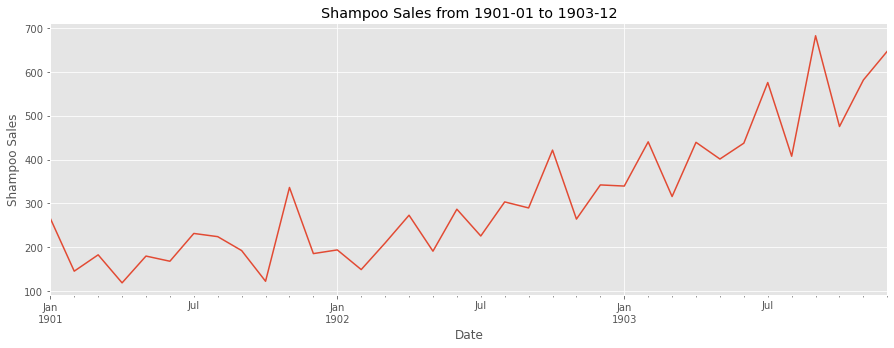

In [52]:
# STATIONARITY CHECK
df.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
start = df.index[0].strftime("%Y-%m")
end = df.index[-1].strftime("%Y-%m")
plt.title('Shampoo Sales from ' + start + ' to ' + end);
# From the plot of the time series data, it is clear that series is non stationary as the mean and standard deviation 
# evolves with time. This indicates that some degree of differencing will be needed to be applied using the ARIMA model

# 3.1  AUTOCORRELATION CHECK (LAG PLOTS )

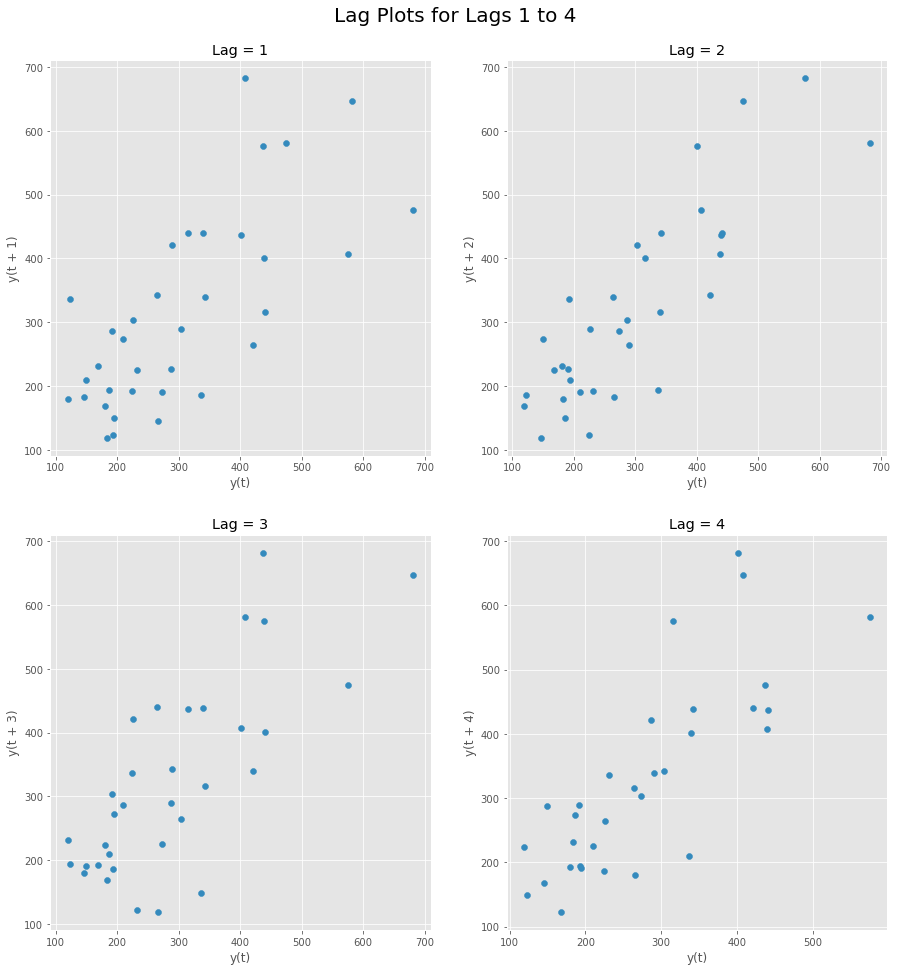

In [53]:
# AUTOCORRELATION CHECK (LAG PLOTS )
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
fig.suptitle("Lag Plots for Lags 1 to 4",size=20)
fig.subplots_adjust(top=0.93)
ax1.title.set_text('Lag = 1');
ax2.title.set_text('Lag = 2');
ax3.title.set_text('Lag = 3');
ax4.title.set_text('Lag = 4');
lag_plot(df,ax=ax1,lag=1);
lag_plot(df,ax=ax2,lag=2);
lag_plot(df,ax=ax3,lag=3);
lag_plot(df,ax=ax4,lag=4);
# Lag plots with various lag values are plotted to demonstrate the positive auto correlation of the observations to its various
# lag values. For the lag values 1 to 4, positive auto correlation can be seen. Plotting graphs and manually observing the
# autocorrelation can be tedious. The in-built auto-correlation function from the pandas library makes this process easier

# 3.2 AUTOCORRELATION CHECK (AUTOCORRELATION PLOT )

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

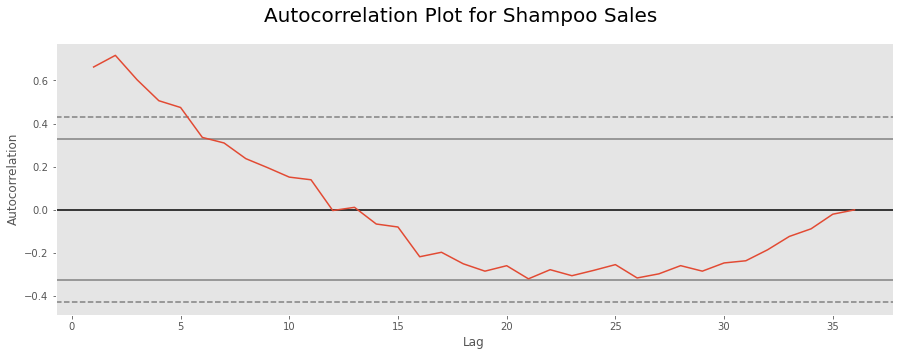

In [54]:
# AUTOCORRELATION CHECK (AUTOCORRELATION PLOT )
# An autocorrelation plot is plotted using the inbuilt pandas function 
fig, ax1 = plt.subplots(1,figsize=(15,5))
fig.suptitle("Autocorrelation Plot for Shampoo Sales",size=20)
autocorrelation_plot(df,ax=ax1)
# This makes the above process in 3.1) easier to view and quantify the degree of autocorrelation
# The horizontal lines in the plot correspond to 95% and 99% confidence bands.
# The dashed line is the 99% confidence band.
# There exist positive correlation for lags up till 10 -12 and they are siginificant for lags below 5
# Therefore, in the following ARIMA model, a lag value of 5 will be a good starting point for the ARIMA model
# Should significant negative correlation exist, a MA model will be more suitable
# i.e given the parameters p,q,d.
# An AR only model will have a positive value for p and a 0 for d
# A MA only model will have a positive value for d and a 0 for p
# A mix model will have a positive value for d and p but this is known to be a rare usage

# 4. Split Data

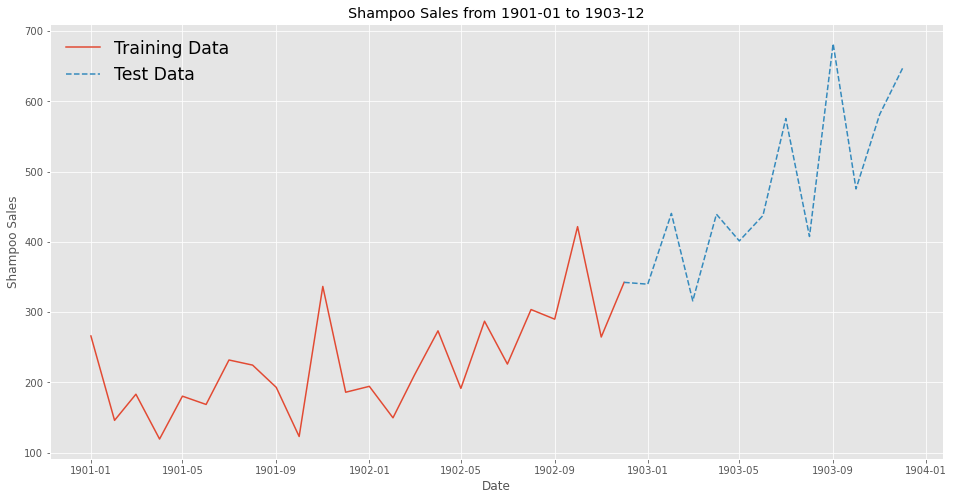

In [55]:
# #Split data in train and test
data = df.values
train , test = data[0:int(len(df)*0.66)] , data[int(len(df)*0.66):] 

# Visualising the split
plt.figure( figsize = (16,8) )
plt.plot( df[0:int(len(df)*0.66)+1] ,label='Training Data')
plt.plot( df[int(len(df)*0.66):]    ,label='Test Data',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
plt.title('Shampoo Sales from ' + start + ' to ' + end);
plt.legend(fontsize='xx-large',frameon=False)

# 5. Instantiate, Train ARIMA Model and Plot Results

Test MSE: 6958.325


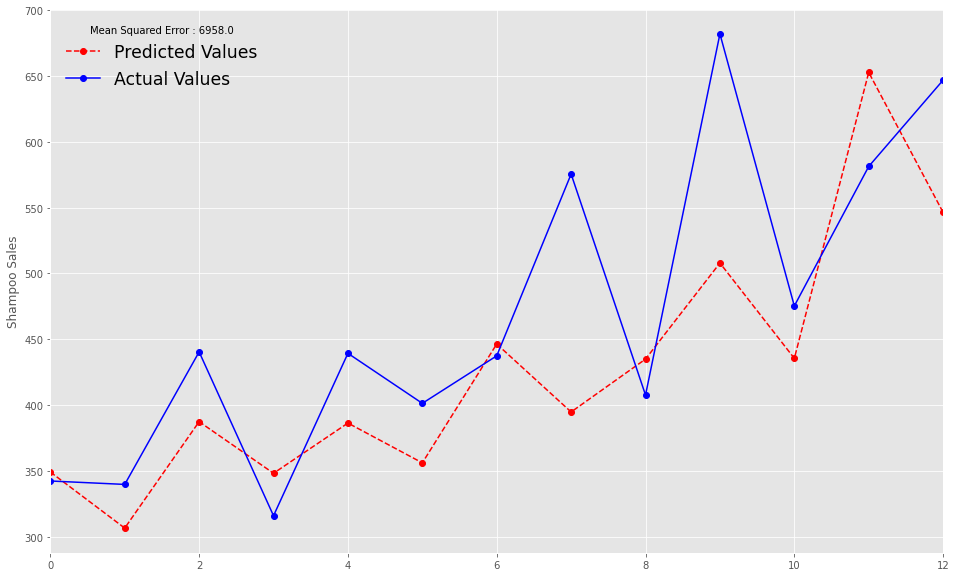

In [72]:
# Walk through each element in the test dataset.
# Train an ARIMA model.
# Make a one-step prediction.
# Store prediction and store actual observation (move from test to history).
# The next prediction step will use a model trained on a dataset that includes the previous test element
# This is known as ONE-STEP ROLLING FORECAST
predictions = []             
history = [i for i in train] 

for x in range(len(test)):
                   
    model     = ARIMA(history,order=(5,1,0))  # AR only model with a lag of 5 and a differencing set to 1
    model_fit = model.fit(disp=1)             # The fitting of the model to the training data
    output    = model_fit.forecast()
    pred      = float(output[0])
    predictions.append(pred)
    history.append(test[x])
    
error = mean_squared_error(test,predictions)  # Mean Square Error is calculated between the predictions and the test
print('Test MSE: %.3f' % error)

# with plt.style.context('dark_background'): 
plt.figure(figsize=(16,10))
plt.plot(predictions,'r--o',label='Predicted Values')
plt.plot(test,'b-o',label='Actual Values')
plt.xlim([0,12])
plt.ylabel("Shampoo Sales")
plt.legend(fontsize='xx-large',title = 'Mean Squared Error : '+ str(round(error,0)),frameon=False,loc=2)

In [57]:
# Another version of Autocorrelation plot and partial autocorrelation plot 
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# fig_first=plot_acf(df,use_vlines=True)
# fig_first=plot_pacf(df,use_vlines=True)
# #gradual decreases on the partial autocor plot suggest using a moving average model
# #sharp drop on the partial autocor plot suggest using a AR model

# Performing HyperParamaters Grid Search 

Grid Searching is used to automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters. The "grid" refers to the space of all the combinations of possible model hyperparameters to be tested This is known as grid searching and is part of model tuning

There are 2 parts:
* Instantiating an ARIMA model and evaluating it on a single set of parameters
* Evaluating multiple sets of ARIMA parameters 

In [58]:
def evaluate_arima_model(X,arima_order):
    
    train , test = X[0:int(len(X)*0.66)] , X[int(len(X)*0.66):]
    predictions  = []
    history      = [i for i in train]
    
    for x in range(len(test)):
        
        model     = ARIMA(history,arima_order) 
        model_fit = model.fit( disp=1 )      
        output    = model_fit.forecast()
        pred      = float(output[0])
        predictions.append(pred)
        history.append(test[x])
        
    error = mean_squared_error(test,predictions)
    return error,test,predictions                               

In [59]:
# Loop through the range of values of p q d by specifying a grid of values
def evaluate_models(dataset,p_values,d_values,q_values):
    
    dataset = dataset.astype('float32')  #converts the input values to type float 32 integers (not doing so causes errors?)
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p,d,q)           #Store parameters for the step in tuple
                try:        
                    error,_,_ = evaluate_arima_model(dataset,arima_order)
                    if error <= best_score:     #Record the best scores based on lowest MSE value
                        
                        best_score = error     
                        best_cfg   = arima_order
                    print('ARIMA%s MSE=%.0f' % (arima_order,error))
                except:
                    continue
                    
    print('Best ARIMA Configuration is %s with an MSE of %.0f' %(best_cfg,best_score))
    return best_score, best_cfg

In [60]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 5)
q_values = range(0, 5)
best_score, best_cfg = evaluate_models(data,p_values,d_values,q_values)

ARIMA(0, 0, 0) MSE=52425
ARIMA(0, 0, 1) MSE=38145
ARIMA(0, 0, 2) MSE=23990
ARIMA(0, 1, 0) MSE=18003
ARIMA(0, 1, 1) MSE=9559
ARIMA(0, 1, 2) MSE=6306
ARIMA(0, 1, 3) MSE=6716
ARIMA(0, 1, 4) MSE=8098
ARIMA(0, 2, 0) MSE=67340
ARIMA(0, 2, 1) MSE=18321
ARIMA(0, 2, 3) MSE=3938
ARIMA(1, 0, 0) MSE=23113
ARIMA(1, 0, 2) MSE=7333
ARIMA(1, 1, 0) MSE=7121
ARIMA(1, 1, 1) MSE=7004
ARIMA(1, 2, 0) MSE=18608
ARIMA(2, 0, 0) MSE=10177
ARIMA(2, 1, 0) MSE=5690
ARIMA(2, 1, 1) MSE=7760
ARIMA(2, 2, 0) MSE=9861
ARIMA(4, 0, 0) MSE=9762
ARIMA(4, 1, 0) MSE=6650
ARIMA(4, 1, 1) MSE=6796
ARIMA(4, 2, 0) MSE=7596
ARIMA(4, 2, 1) MSE=4695
ARIMA(6, 1, 0) MSE=6810
ARIMA(6, 1, 1) MSE=4496
ARIMA(6, 2, 0) MSE=6261
ARIMA(8, 1, 0) MSE=6579
ARIMA(10, 1, 0) MSE=7543
Best ARIMA Configuration is (0, 2, 3) with an MSE of 3938


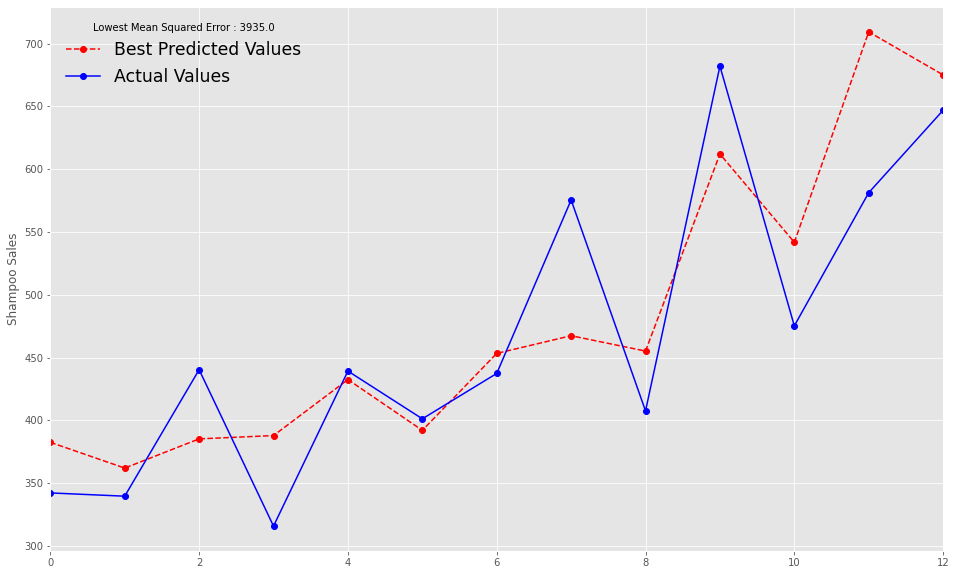

In [71]:
# PLOT LOWEST MSE PREDICTION
best_score,test,predictions = evaluate_arima_model(data,best_cfg)
plt.figure(figsize=(16,10))
plt.plot(predictions,'r--o',label = 'Best Predicted Values')
plt.plot(test,'b-o',label = 'Actual Values')
plt.xlim([0,12])
plt.ylabel("Shampoo Sales")
# plt.legend()
plt.legend(fontsize='xx-large',title = 'Lowest Mean Squared Error : '+ str(round(best_score,0)),frameon=False,loc=2)